<a href="https://colab.research.google.com/github/MoritzHaw/BPI2019_Colabatory/blob/main/HandleData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py

     |████████████████████████████████| 1.8 MB 8.5 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23597 sha256=84a35aef0d0a96690c26c4b0645657e5b8e0987a3c34e60154001e87f55a7d0f
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [ ]:
import pm4py
import pandas as pd
import numpy as np

In [ ]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

log_csv = pd.read_csv('http://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip', encoding='cp1252',sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

In [ ]:
log_csv.rename(columns={'eventID':'eventID', 'case Spend area text': 'case:spend:area', 'case Company': 'case:company', 'case Document Type':'case:doc:type',\
                        'case Sub spend area text': 'case:spend:area:text','case Purchasing Document':'case:doc:id',\
                        'case Purch. Doc. Category name':'case:purch:category', 'case Vendor':'case:vendor', 'case Item Type': 'case:item:type',\
                        'case Item Category': 'case:item:category', 'case Spend classification text':'case:purch:class',	'case Source': 'case:source',\
                        'case Name':'case:vendor:name', 'case GR-Based Inv. Verif.': 'case:invoicing:required', 'case Item': 'case:item',\
                        'case concept:name': 'case:concept:name', 'case Goods Receipt': 'case:goods:receipt', 'event User': 'event:user',\
                        'event org:resource': 'org:resource', 'event concept:name': 'concept:name', 'event Cumulative net worth (EUR)': 'cumulative:net:worth:EUR',\
                        'event time:timestamp': 'time:timestamp'}, inplace=True)

In [ ]:
log_csv['case:concept:name'].count()

1595923

In [ ]:
def to_eventlog(dataset):
  # Convert log_csv to event_log
  parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}  # identify the case_id_key name (if not change it will simply be the nane of the coloumn)
  event_log = log_converter.apply(dataset, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
  return event_log

In [ ]:
event_log = to_eventlog(log_csv)

In [ ]:
# calculate percentage of cases which werent in 2018

date_percentage = log_csv[log_csv['time:timestamp'].between('2018-01-01 00:00:00', '2018-12-31 23:59:00')].count()
percentage = 100 - (date_percentage['case:concept:name']/log_csv['case:concept:name'].count()) * 100
print(percentage)
#log_csv.groupby['case:concept:name']('time:timestamp').between('2018-01-01 00:00:00', '2018-12-31 23:59:00').count()

2.8481950570296846


In [ ]:
from pm4py.algo.filtering.log.timestamp import timestamp_filter # filter between dates
 
def filter_by_period(dataset, eventlog, date1: str, date2: str):
        '''
        :param dataset: dataset, which should be filtered
        :param date1: startdate
        :param date2: enddate
        :return: filtered eventlog
        '''
        filtered_log = timestamp_filter.filter_traces_contained(eventlog, date1, date2)
        df_filtered_by_period = log_converter.apply(
            filtered_log, variant=log_converter.Variants.TO_DATA_FRAME)
        return df_filtered_by_period, filtered_log

log_filtered_byDate, event_log_date = filter_by_period(log_csv, event_log, 
                                                       "2018-01-01 00:00:00", 
                                                       "2019-01-28 23:59:00")

[{'attributes': {'spend:area': 'Additives', 'company': 'companyID_0000', 'doc:type': 'Standard PO', 'spend:area:text': 'Extenders', 'doc:id': 4507000672, 'purch:category': 'Purchase order', 'vendor': 'vendorID_0321', 'item:type': 'Standard', 'item:category': '3-way match, invoice before GR', 'purch:class': 'PR', 'source': 'sourceSystemID_0000', 'vendor:name': 'vendor_0312', 'invoicing:required': False, 'item': 10, 'concept:name': '4507000672_00010', 'goods:receipt': True}, 'events': [{'eventID ': 6609954668547, 'event:user': 'NONE', 'org:resource': 'NONE', 'concept:name': 'Vendor creates invoice', 'cumulative:net:worth:EUR': 6304.0, 'time:timestamp': Timestamp('2018-01-26 23:59:00+0000', tz='UTC'), 'case:spend:area': 'Additives', 'case:company': 'companyID_0000', 'case:doc:type': 'Standard PO', 'case:spend:area:text': 'Extenders', 'case:doc:id': 4507000672, 'case:purch:category': 'Purchase order', 'case:vendor': 'vendorID_0321', 'case:item:type': 'Standard', 'case:item:category': '3-wa

In [ ]:
log_date_nunique = log_filtered_byDate.nunique().sort_values(ascending=False)
#log_nunique.to_excel('/content/excel/log_nunique.xlsx')
log_date_nunique
log_filtered_byDate.value_counts('case:item:type')

case:item:type
Standard          1088113
Service            240987
Consignment         34717
Third-party         26014
Subcontracting      20508
Limit                4449
dtype: int64

In [ ]:
# count occurrences of concept:name to analyze which values are important

def count_occurrences(log, column: str):
        """
        :param column: name of the column where the values should be counted
        :return: counted occurences of column values
        """
        count_column = log.groupby(column).count()
        return count_column



In [ ]:
event_log_date

[{'attributes': {'spend:area': 'Packaging', 'company': 'companyID_0000', 'doc:type': 'Standard PO', 'spend:area:text': 'Labels', 'doc:id': 4507000221, 'purch:category': 'Purchase order', 'vendor': 'vendorID_0103', 'item:type': 'Standard', 'item:category': '3-way match, invoice before GR', 'purch:class': 'PR', 'source': 'sourceSystemID_0000', 'vendor:name': 'vendor_0103', 'invoicing:required': False, 'item': 10, 'concept:name': '4507000221_00010', 'goods:receipt': True}, 'events': [{'eventID ': 1430224109568, 'event:user': 'batch_03', 'org:resource': 'batch_03', 'concept:name': 'Create Purchase Order Item', 'cumulative:net:worth:EUR': 208.0, 'time:timestamp': Timestamp('2018-01-01 03:42:00+0000', tz='UTC'), 'case:spend:area': 'Packaging', 'case:company': 'companyID_0000', 'case:doc:type': 'Standard PO', 'case:spend:area:text': 'Labels', 'case:doc:id': 4507000221, 'case:purch:category': 'Purchase order', 'case:vendor': 'vendorID_0103', 'case:item:type': 'Standard', 'case:item:category': 

# Bar chart to compare filter

In [ ]:
def count_events(dataset):
  return dataset['case:concept:name'].count()

In [ ]:
# decrease percent

def decrease_in_perc(dataset1, dataset2):
  return 1 - count_events(dataset2)/count_events(dataset1)

In [ ]:
# compare before and after filtering date 

import matplotlib.pyplot as plt
import seaborn as sns

def comp_bef_aft(dataset1 , dataset2):

    plt.style.use('ggplot')

    x = ['without filtering', 'after filtering']
    events = [count_events(dataset1), count_events(dataset2)]

    x_pos = [i for i, _ in enumerate(x)]
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    color = sns.color_palette("muted")
    plt.figure(1, figsize=(5, 5))  # size
    plt.bar(x_pos, events, color=color)
    plt.xlabel("Filter")
 
    plt.ylabel("Events")
    #plt.title("Energy output from various fuel sources")
    plt.grid(False)

    plt.xticks(x_pos, x)
    plt.axhline(y=0, color='black')

    plt.show()

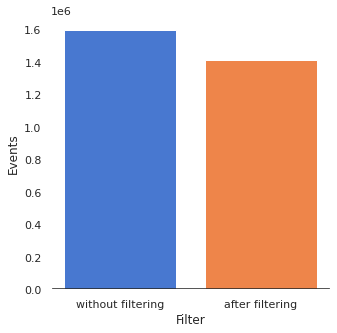

In [ ]:
comp_bef_aft(log_csv, log_filtered_byDate)

# Filtering Data Functions

In [ ]:
#from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.pandas.attributes import attributes_filter

def filter_log_by_cat(log, item_category: str):
    '''
    :log: dataset
    :item_category: e.g. "3-way match, invoice after GR"
    filter data by case item category
    :return: filtered data IVaGR
    '''
    #tracefilter_cat = attributes_filter.apply(e_log, [item_category],parameters={
     #                                                   attributes_filter.Parameters.ATTRIBUTE_KEY: "case:item:category", attributes_filter.Parameters.POSITIVE: True})
    
    df_tracefilter_cat = attributes_filter.apply(log, [item_category], 
                                          parameters={attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name", attributes_filter.Parameters.ATTRIBUTE_KEY: "case:item:category", attributes_filter.Parameters.POSITIVE: True})

    return df_tracefilter_cat

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.pandas import case_statistics
from pm4py.statistics.traces.generic.pandas import case_statistics

def filter_by_variants(dataset):
      variants = case_statistics.get_variants_df(dataset, parameters={
                                                        case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                        case_statistics.Parameters.ACTIVITY_KEY: "concept:name"})
      return variants

def variants_statistics(dataset):
      variants_count = case_statistics.get_variant_statistics(dataset,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name"})
      return variants_count

In [ ]:
def merge_df(data1, data2, on):
      merge_df = pd.merge(data1, data2, on=on)
      return merge_df

# Filtering IVaGR

In [ ]:
log_filtered_IVaGR = filter_log_by_cat(log_filtered_byDate, "3-way match, invoice after GR")
log_filtered_IVaGR

,eventID,event:user,org:resource,concept:name,cumulative:net:worth:EUR,time:timestamp,case:spend:area,case:company,case:doc:type,case:spend:area:text,case:doc:id,case:purch:category,case:vendor,case:item:type,case:item:category,case:purch:class,case:source,case:vendor:name,case:invoicing:required,case:item,case:concept:name,case:goods:receipt
63,1473173782528,user_033,user_033,Create Purchase Order Item,43301.0,2018-02-01 07:23:00+00:00,Specialty Resins,companyID_0000,Standard PO,Alkyd Resins,4507000227,Purchase order,vendorID_0107,Standard,"3-way match, invoice after GR",PR,sourceSystemID_0000,vendor_0107,True,10,4507000227_00010,True
64,1473173782529,NONE,NONE,Vendor creates invoice,43301.0,2018-01-15 23:59:00+00:00,Specialty Resins,companyID_0000,Standard PO,Alkyd Resins,4507000227,Purchase order,vendorID_0107,Standard,"3-way match, invoice after GR",PR,sourceSystemID_0000,vendor_0107,True,10,4507000227_00010,True
65,1473173782530,user_035,user_035,Record Goods Receipt,43301.0,2018-01-16 12:05:00+00:00,Specialty Resins,companyID_0000,Standard PO,Alkyd Resins,4507000227,Purchase order,vendorID_0107,Standard,"3-way match, invoice after GR",PR,sourceSystemID_0000,vendor_0107,True,10,4507000227_00010,True
66,1473173782531,batch_00,batch_00,Record Invoice Receipt,43301.0,2018-01-17 15:48:00+00:00,Specialty Resins,companyID_0000,Standard PO,Alkyd Resins,4507000227,Purchase order,vendorID_0107,Standard,"3-way match, invoice after GR",PR,sourceSystemID_0000,vendor_0107,True,10,4507000227_00010,True
67,1473173782532,user_002,user_002,Clear Invoice,43301.0,2018-03-29 15:06:00+00:00,Specialty Resins,companyID_0000,Standard PO,Alkyd Resins,4507000227,Purchase order,vendorID_0107,Standard,"3-way match, invoice after GR",PR,sourceSystemID_0000,vendor_0107,True,10,4507000227_00010,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414660,1076701056467002,batch_02,batch_02,Record Goods Receipt,2577.0,2018-12-31 23:34:00+00:00,Logistics,companyID_0000,Standard PO,Road Packed,4508075963,Purchase order,vendorID_0234,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0229,True,1,4508075963_00001,True
1414661,1076701056466995,NONE,NONE,Record Service Entry Sheet,23.0,2018-12-31 23:34:00+00:00,Logistics,companyID_0000,Standard PO,Road Packed,4508075963,Purchase order,vendorID_0234,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0229,True,1,4508075963_00001,True
1414662,1076701056466996,NONE,NONE,Record Service Entry Sheet,71.0,2018-12-31 23:34:00+00:00,Logistics,companyID_0000,Standard PO,Road Packed,4508075963,Purchase order,vendorID_0234,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0229,True,1,4508075963_00001,True
1414663,1076701056467001,NONE,NONE,Record Service Entry Sheet,47.0,2018-12-31 23:34:00+00:00,Logistics,companyID_0000,Standard PO,Road Packed,4508075963,Purchase order,vendorID_0234,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0229,True,1,4508075963_00001,True


In [ ]:
variants_IVaGR = filter_by_variants(log_filtered_IVaGR)
variants_IVaGR

,variant
case:concept:name,
2000000001_00001,"SRM: Created,SRM: Document Completed,SRM: Awai..."
2000000002_00001,"SRM: Created,SRM: Complete,SRM: Document Compl..."
2000000005_00002,"SRM: Created,SRM: Awaiting Approval,SRM: Docum..."
2000000006_00001,"SRM: Created,SRM: Document Completed,SRM: Comp..."
2000000008_00001,"SRM: Created,SRM: Complete,SRM: Awaiting Appro..."
...,...
4508075945_00001,"Create Purchase Order Item,Record Goods Receip..."
4508075946_00001,"Record Service Entry Sheet,Record Goods Receip..."
4508075947_00001,"Record Service Entry Sheet,Record Goods Receip..."


In [ ]:
variants_contains_GR_IV = variants_IVaGR[(variants_IVaGR['variant'].str.contains('Goods Receipt')) & (variants_IVaGR['variant'].str.contains('Invoice Receipt'))]
variants_contains_GR_IV

,variant
case:concept:name,
2000000001_00001,"SRM: Created,SRM: Document Completed,SRM: Awai..."
2000000002_00001,"SRM: Created,SRM: Complete,SRM: Document Compl..."
2000000006_00001,"SRM: Created,SRM: Document Completed,SRM: Comp..."
2000000008_00001,"SRM: Created,SRM: Complete,SRM: Awaiting Appro..."
2000000009_00001,"Vendor creates invoice,SRM: Created,SRM: Chang..."
...,...
4508075812_00440,"Create Purchase Order Item,Vendor creates invo..."
4508075812_00510,"Create Purchase Order Item,Vendor creates invo..."
4508075812_00520,"Create Purchase Order Item,Vendor creates invo..."


In [ ]:
variants_contains_GR_IV['value_GR'] = variants_contains_GR_IV['variant'].str.count('Record Goods Receipt')
variants_contains_GR_IV['value_IV'] = variants_contains_GR_IV['variant'].str.count('Record Invoice Receipt')

#merged_values = pd.merge(variants_value_GR, variants_value_IV, on=['case:concept:name'], how='inner')
#merged_values

#variants_contains_GR_IV.drop(['case:concept:name'])

variants_contains_GR_IV = variants_contains_GR_IV[variants_contains_GR_IV.value_IV == variants_contains_GR_IV.value_GR]
variants_contains_GR_IV



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,variant,value_GR,value_IV
case:concept:name,,,
2000000001_00001,"SRM: Created,SRM: Document Completed,SRM: Awai...",1,1
2000000006_00001,"SRM: Created,SRM: Document Completed,SRM: Comp...",1,1
2000000008_00001,"SRM: Created,SRM: Complete,SRM: Awaiting Appro...",1,1
2000000009_00001,"Vendor creates invoice,SRM: Created,SRM: Chang...",1,1
2000000011_00001,"SRM: Created,SRM: Ordered,SRM: Awaiting Approv...",1,1
...,...,...,...
4508075812_00440,"Create Purchase Order Item,Vendor creates invo...",1,1
4508075812_00510,"Create Purchase Order Item,Vendor creates invo...",1,1
4508075812_00520,"Create Purchase Order Item,Vendor creates invo...",1,1


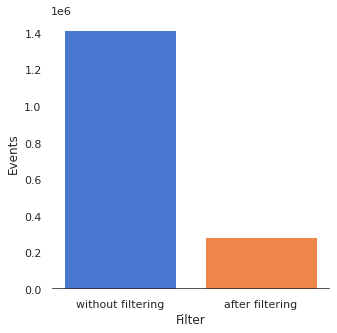

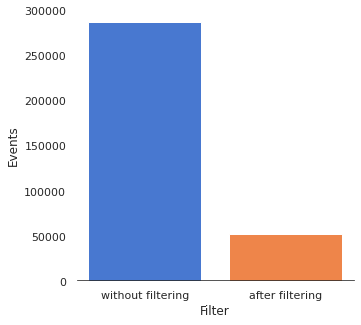

In [ ]:
# merge dataframes
df_IVaGR = merge_df(log_filtered_IVaGR, variants_contains_GR_IV, 'case:concept:name')
#df_IVaGR_containsGR_IV.value_counts('concept:name')

#df_IVaGR_containsGR_IV.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
df_IVaGR.to_pickle('PKL_IVaGR_filtered')
comp_bef_aft(log_filtered_byDate, log_filtered_IVaGR)
comp_bef_aft(log_filtered_IVaGR, df_IVaGR)

In [ ]:
count_events(df_IVaGR)
decrease_in_perc(log_filtered_IVaGR, df_IVaGR)

0.8181967024660092

In [ ]:
#filtered_log = pm4py.filter_variants_top_k(df_IVaGR , 25)
#filtered_log.value_counts('concept:name')

In [ ]:
#filtered_log_2 = variants_filter.filter_variants_variants_percentage(event_log, variants_contains_GR_IV, variants_percentage=0.5)

#filtered_log_2

# Filtering IVbGR

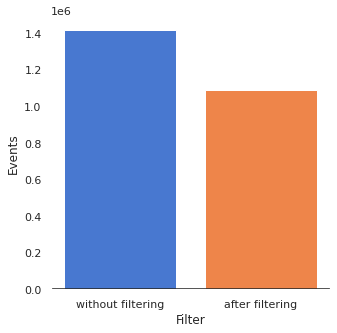

1088559

In [ ]:
log_filtered_IVbGR = filter_log_by_cat(log_filtered_byDate, "3-way match, invoice before GR") 
comp_bef_aft(log_filtered_byDate, log_filtered_IVbGR)
decrease_in_perc(log_filtered_byDate, log_filtered_IVbGR)
count_events(log_filtered_IVbGR)

In [ ]:
variants_IVbGR = filter_by_variants(log_filtered_IVbGR)
variants_IVbGR

,variant
case:concept:name,
2000000000_00001,"SRM: Created,SRM: Change was Transmitted,SRM: ..."
2000000003_00001,"SRM: Created,SRM: Change was Transmitted,SRM: ..."
2000000003_00002,"SRM: Created,SRM: Change was Transmitted,SRM: ..."
2000000003_00003,"SRM: Created,SRM: Awaiting Approval,SRM: Docum..."
2000000004_00001,"SRM: Created,SRM: In Transfer to Execution Sys..."
...,...
4508075961_00020,"Create Purchase Requisition Item,Create Purcha..."
4508075961_00030,"Create Purchase Requisition Item,Create Purcha..."
4508075961_00040,"Create Purchase Order Item,Vendor creates invo..."


In [ ]:
variants_contains_GR = variants_IVbGR[(variants_IVbGR['variant'].str.contains('Goods Receipt'))]
variants_contains_GR

,variant
case:concept:name,
2000000000_00001,"SRM: Created,SRM: Change was Transmitted,SRM: ..."
2000000003_00001,"SRM: Created,SRM: Change was Transmitted,SRM: ..."
2000000003_00002,"SRM: Created,SRM: Change was Transmitted,SRM: ..."
2000000003_00003,"SRM: Created,SRM: Awaiting Approval,SRM: Docum..."
2000000004_00001,"SRM: Created,SRM: In Transfer to Execution Sys..."
...,...
4508075961_00020,"Create Purchase Requisition Item,Create Purcha..."
4508075961_00030,"Create Purchase Requisition Item,Create Purcha..."
4508075961_00040,"Create Purchase Order Item,Vendor creates invo..."


In [ ]:
# Value of invoice receipts = value of clear invoice message = value of vendor creates invoice

variants_contains_GR['value_CIV'] = variants_contains_GR['variant'].str.count('Clear Invoice')
variants_contains_GR['value_IV'] = variants_contains_GR['variant'].str.count('Record Invoice Receipt')
variants_contains_GR['value_NIV'] = variants_contains_GR['variant'].str.count('Vendor creates invoice')

#merged_values = pd.merge(variants_value_GR, variants_value_IV, on=['case:concept:name'], how='inner')
#merged_values

#variants_contains_GR_IV.drop(['case:concept:name'])

variants_contains_CIV_IV_NIV = variants_contains_GR[(variants_contains_GR.value_CIV == variants_contains_GR.value_IV) & (variants_contains_GR.value_CIV == variants_contains_GR.value_NIV)]
variants_contains_CIV_IV_NIV


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,variant,value_CIV,value_IV,value_NIV
case:concept:name,,,,
2000000000_00001,"SRM: Created,SRM: Change was Transmitted,SRM: ...",1,1,1
2000000003_00001,"SRM: Created,SRM: Change was Transmitted,SRM: ...",1,1,1
2000000003_00002,"SRM: Created,SRM: Change was Transmitted,SRM: ...",1,1,1
2000000003_00003,"SRM: Created,SRM: Awaiting Approval,SRM: Docum...",1,1,1
2000000004_00001,"SRM: Created,SRM: In Transfer to Execution Sys...",1,1,1
...,...,...,...,...
4508075954_00110,"Create Purchase Requisition Item,Create Purcha...",0,0,0
4508075954_00120,"Create Purchase Requisition Item,Create Purcha...",0,0,0
4508075954_00130,"Create Purchase Requisition Item,Create Purcha...",0,0,0


In [ ]:
# merge dataframes
df_IVbGR = merge_df(log_filtered_IVbGR, variants_contains_CIV_IV_NIV, 'case:concept:name')
df_IVbGR

#df_IVbGR.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
df_IVbGR.to_pickle('PKL_IVbGR_filtered')
decrease_in_perc(log_filtered_IVbGR, df_IVbGR)
#comp_bef_aft(log_filtered_IVbGR, df_IVbGR)
count_events(df_IVbGR)

889866

In [ ]:
#df_IVbGR.to_csv('CSV_IVbGR_filtered',  encoding='cp1252',sep=',')

# Outer Join on IVaGR and IVbGR for Task2

In [ ]:
IVaGR_IVbGR = pd.merge(df_IVaGR, df_IVbGR, how='outer')
IVaGR_IVbGR.to_csv('IVaGR_IVbGR.zip', compression='zip')

# Filtering nGR

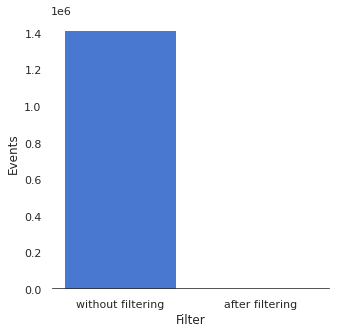

0.99685535924817

In [ ]:
log_filtered_nGR = filter_log_by_cat(log_filtered_byDate, "2-way match")
comp_bef_aft(log_filtered_byDate, log_filtered_nGR) 
count_events(log_filtered_nGR)
decrease_in_perc(log_filtered_byDate, log_filtered_nGR)

In [ ]:
variants_nGR = filter_by_variants(log_filtered_nGR)
variants_nGR

,variant
case:concept:name,
4507075964_00020,"Change Approval for Purchase Order,Vendor crea..."
4507075965_00030,"Create Purchase Order Item,Change Approval for..."
4507075965_00040,"Create Purchase Order Item,Change Approval for..."
4507075965_00050,"Create Purchase Order Item,Change Approval for..."
4507075965_00060,"Create Purchase Order Item,Change Approval for..."
...,...
4508076348_00070,"Create Purchase Order Item,Change Approval for..."
4508076348_00080,"Create Purchase Order Item,Change Approval for..."
4508076348_00090,"Create Purchase Order Item,Change Approval for..."


In [ ]:
variants_contains_IV = variants_nGR[(variants_nGR['variant'].str.contains('Invoice Receipt'))]
variants_contains_IV

,variant
case:concept:name,
4507075964_00020,"Change Approval for Purchase Order,Vendor crea..."
4507075965_00050,"Create Purchase Order Item,Change Approval for..."
4507075965_00060,"Create Purchase Order Item,Change Approval for..."
4507075965_00090,"Create Purchase Order Item,Change Approval for..."
4507075965_00110,"Create Purchase Order Item,Change Approval for..."
...,...
4508076344_00010,"Vendor creates invoice,Create Purchase Order I..."
4508076345_00130,"Vendor creates invoice,Change Approval for Pur..."
4508076346_00010,"Vendor creates invoice,Create Purchase Order I..."


In [ ]:
variants_contains_IV['value_IV'] = variants_contains_IV['variant'].str.count('Record Invoice Receipt')
variants_contains_IV['value_NIV'] = variants_contains_IV['variant'].str.count('Vendor creates invoice')

#merged_values = pd.merge(variants_value_GR, variants_value_IV, on=['case:concept:name'], how='inner')
#merged_values

#variants_contains_GR_IV.drop(['case:concept:name'])

variants_contains_IV_NIV = variants_contains_IV[variants_contains_IV.value_IV == variants_contains_IV.value_NIV]
variants_contains_IV_NIV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,variant,value_IV,value_NIV
case:concept:name,,,
4507075964_00020,"Change Approval for Purchase Order,Vendor crea...",1,1
4507075965_00050,"Create Purchase Order Item,Change Approval for...",1,1
4507075965_00060,"Create Purchase Order Item,Change Approval for...",1,1
4507075965_00090,"Create Purchase Order Item,Change Approval for...",1,1
4507075965_00110,"Create Purchase Order Item,Change Approval for...",1,1
...,...,...,...
4508076344_00010,"Vendor creates invoice,Create Purchase Order I...",1,1
4508076345_00130,"Vendor creates invoice,Change Approval for Pur...",1,1
4508076346_00010,"Vendor creates invoice,Create Purchase Order I...",1,1


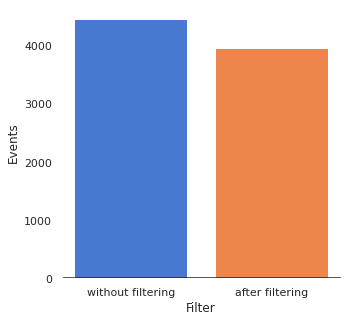

In [ ]:
df_nGR = merge_df(log_filtered_nGR, variants_contains_IV_NIV, 'case:concept:name')

df_nGR.to_pickle('PKL_nGR_filtered')
#df_nGR.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
decrease_in_perc(log_filtered_nGR, df_nGR)
comp_bef_aft(log_filtered_nGR, df_nGR)
#count_events(df_nGR)

In [ ]:
#df_nGR_containsIV.to_csv('CSV_nGR_filtered',  encoding='cp1252',sep=',')

# Filtering Con

In [ ]:
log_filtered_Con = filter_log_by_cat(log_filtered_byDate, "Consignment")
log_filtered_Con

#count_events(log_filtered_Con)
#decrease_in_perc(log_filtered_byDate, log_filtered_Con)
#comp_bef_aft(log_filtered_byDate, log_filtered_Con)

,eventID,event:user,org:resource,concept:name,cumulative:net:worth:EUR,time:timestamp,case:spend:area,case:company,case:doc:type,case:spend:area:text,case:doc:id,case:purch:category,case:vendor,case:item:type,case:item:category,case:purch:class,case:source,case:vendor:name,case:invoicing:required,case:item,case:concept:name,case:goods:receipt
871,2065879269376,user_043,user_043,Create Purchase Order Item,0.0,2018-02-01 08:51:00+00:00,Additives,companyID_0000,Standard PO,Extenders,4507000256,Purchase order,vendorID_0126,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0125,False,10,4507000256_00010,True
872,2065879269377,user_044,user_044,Record Goods Receipt,0.0,2018-10-01 12:39:00+00:00,Additives,companyID_0000,Standard PO,Extenders,4507000256,Purchase order,vendorID_0126,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0125,False,10,4507000256_00010,True
873,2065879269378,user_043,user_043,Change Quantity,0.0,2018-09-02 16:55:00+00:00,Additives,companyID_0000,Standard PO,Extenders,4507000256,Purchase order,vendorID_0126,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0125,False,10,4507000256_00010,True
1147,2276332666880,user_052,user_052,Create Purchase Order Item,0.0,2018-02-01 09:51:00+00:00,Packaging,companyID_0000,Standard PO,Plastic Containers & Lids < 30L,4507000265,Purchase order,vendorID_0134,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0133,False,20,4507000265_00020,True
1148,2276332666881,user_053,user_053,Record Goods Receipt,0.0,2018-01-18 11:02:00+00:00,Packaging,companyID_0000,Standard PO,Plastic Containers & Lids < 30L,4507000265,Purchase order,vendorID_0134,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0133,False,20,4507000265_00020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412997,1074940119875584,user_142,user_142,Create Purchase Order Item,0.0,2018-12-21 13:18:00+00:00,Packaging,companyID_0000,Standard PO,Metal Containers & Lids < 30L,4508075833,Purchase order,vendorID_0181,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0179,False,30,4508075833_00030,True
1412998,1074940119875585,user_080,user_080,Record Goods Receipt,0.0,2019-01-14 13:12:00+00:00,Packaging,companyID_0000,Standard PO,Metal Containers & Lids < 30L,4508075833,Purchase order,vendorID_0181,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0179,False,30,4508075833_00030,True
1412999,1074935824908288,user_142,user_142,Create Purchase Order Item,0.0,2018-12-21 13:18:00+00:00,Packaging,companyID_0000,Standard PO,Metal Containers & Lids < 30L,4508075833,Purchase order,vendorID_0181,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0179,False,20,4508075833_00020,True
1414707,1067183408939008,user_102,user_102,Create Purchase Order Item,0.0,2019-10-01 10:21:00+00:00,Pigments & Colorants,companyID_0000,Standard PO,Colorants,4508075359,Purchase order,vendorID_0449,Consignment,Consignment,PR,sourceSystemID_0000,vendor_0436,False,20,4508075359_00020,True


In [ ]:
variants_Con = filter_by_variants(log_filtered_Con)
variants_Con

,variant
case:concept:name,
4507000256_00010,"Create Purchase Order Item,Record Goods Receip..."
4507000265_00010,"Create Purchase Order Item,Record Goods Receipt"
4507000265_00020,"Create Purchase Order Item,Record Goods Receipt"
4507000283_00010,"Create Purchase Order Item,Record Goods Receipt"
4507000284_00010,"Create Purchase Order Item,Record Goods Receipt"
...,...
4508075813_00010,"Create Purchase Requisition Item,Create Purcha..."
4508075816_00010,"Create Purchase Requisition Item,Create Purcha..."
4508075818_00010,"Create Purchase Requisition Item,Create Purcha..."


In [ ]:
# check if GR > 0 and IV = 0

variants_contains_GR = variants_Con[(variants_Con['variant'].str.contains('Goods Receipt')) & (variants_Con['variant'].str.contains('Invoice') == False)]
variants_contains_GR

,variant
case:concept:name,
4507000256_00010,"Create Purchase Order Item,Record Goods Receip..."
4507000265_00010,"Create Purchase Order Item,Record Goods Receipt"
4507000265_00020,"Create Purchase Order Item,Record Goods Receipt"
4507000283_00010,"Create Purchase Order Item,Record Goods Receipt"
4507000284_00010,"Create Purchase Order Item,Record Goods Receipt"
...,...
4508075678_00080,"Create Purchase Order Item,Record Goods Receipt"
4508075678_00120,"Create Purchase Order Item,Record Goods Receipt"
4508075776_00010,"Create Purchase Requisition Item,Create Purcha..."


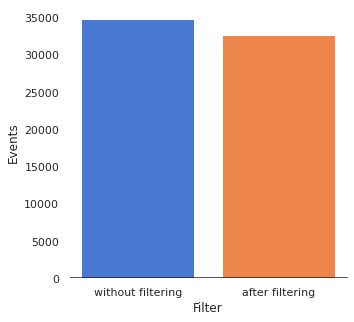

In [ ]:
# merge 
df_Con = merge_df(log_filtered_Con, variants_contains_GR, 'case:concept:name')

df_IVaGR.to_pickle('PKL_Con_filtered')
#df_Con.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
decrease_in_perc(log_filtered_Con, df_Con)
comp_bef_aft(log_filtered_Con, df_Con)
#count_events(df_Con)

In [ ]:
#df_Con.to_csv('CSV_Con_filtered',  encoding='cp1252',sep=',')

# Check on SRM in categories

In [ ]:
#if ((df_Con['variant'].str.contains('SRM')) == True):

#df_Con[df_Con['variant'].str.contains('SRM')].value_counts('case:doc:type')
#df_nGR[df_nGR['variant'].str.contains('SRM')].value_counts('case:doc:type')
df_IVaGR[df_IVaGR['variant'].str.contains('SRM')].value_counts('case:doc:type')
#df_IVbGR[df_IVbGR['variant'].str.contains('SRM')].value_counts('case:doc:type')
#df_IVbGR.value_counts('case:doc:type')
#df_Con.value_counts('case:spend:area')
df_IVaGR.value_counts('case:doc:type')

case:doc:type
Standard PO          41091
EC Purchase order     6349
Framework order       4749
dtype: int64